In [1]:
!pip install pydicom
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.3.1
!pip install --upgrade numpy
!pip install tqdm
!pip install 'h5py<3.0.0'
!pip install tensorflow-estimator==2.1.0
!pip install tensorflow-gpu==2.1.0
!pip install q keras==2.3.1 
!pip install segmentation-models

  Using cached tensorflow_gpu-1.15.0-cp36-cp36m-manylinux2010_x86_64.whl (411.5 MB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.1.0
    Uninstalling tensorflow-gpu-2.1.0:
      Successfully uninstalled tensorflow-gpu-2.1.0
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.1

  Using cached tensorboard-2.1.1-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 1.15.0
    Uninstalling tensorflow-gpu-1.15.0:
      Successfully uninstalled tensorflow-gpu-1.15.0


## Reading dicom image from the Dataset

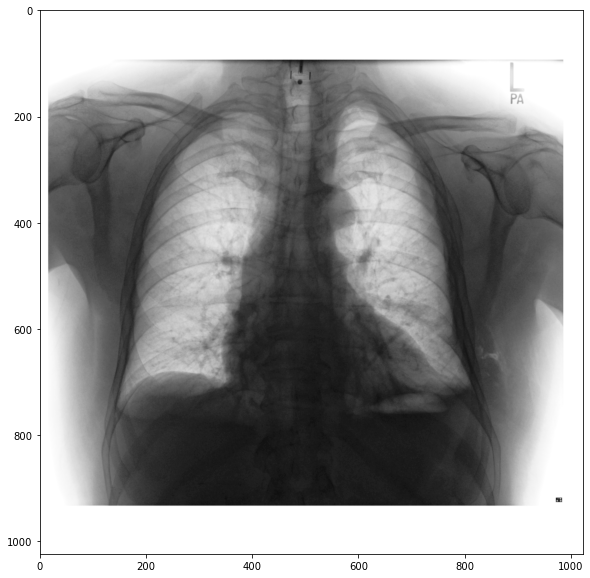

In [2]:
import pydicom as dicom
import cv2   
import numpy as np
import matplotlib.pyplot as plt

# specify your image path
image_path = 'Images/AllData/0.7.50.991450.14.2.8.2.293105394483916.7020685578208.2'
ds = dicom.dcmread(image_path)
pixel_array_numpy = ds.pixel_array
plt.figure(figsize = (10,10))
plt.imshow(pixel_array_numpy,cmap='Greys')

In [3]:
import pandas as pd
mask_df= pd.read_csv('Rib_fracture_mask_rle.csv',nrows=30)
mask_df['anon_SOPUID'][2]

'0.7.50.991450.14.2.8.2.293105394483916.7020685578208.2'

In [4]:
for i in range(30):
    path=mask_df['anon_SOPUID'][i]
    image_path = 'Images/AllData/'+f'{path}'
    ds = dicom.dcmread(image_path)
    pixel_array = ds.pixel_array
    # Normalize pixel_array for pixel intensity
    normalized = pixel_array.astype(np.float32) / pixel_array.max()
    print(pixel_array.max(),normalized.max())

4095 1.0
4095 1.0
4095 1.0
4095 1.0
15172 1.0
16382 1.0
16382 1.0
16382 1.0
3925 1.0
3925 1.0
3925 1.0
15026 1.0
8191 1.0
8191 1.0
8191 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0
4095 1.0


In [5]:
gary2rgb = cv2.cvtColor(pixel_array_numpy,cv2.COLOR_GRAY2RGB)
gary2rgb.shape

(1024, 1024, 3)

## Reading the mask which has rle format

In [6]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (1024, 1024) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    for i in range(2,len(rle_code),2):
        rle_code[i]=rle_code[i]+rle_code[i-2]+rle_code[i-1]

    pixels = [(pixel_position % 1024, pixel_position // 1024) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels
pixels=rle_to_pixels(mask_df.iloc[10,2])
len(pixels)

925

In [7]:
925/(1024*1024) # This implies the total area covered by mask/ positive class is only 0.08% of the total image size

0.0008821487426757812

In [8]:
5112/(1024*1024) # This implies the total area covered by mask/ positive class is only 0.08%-0.5% of the total image size

0.00487518310546875

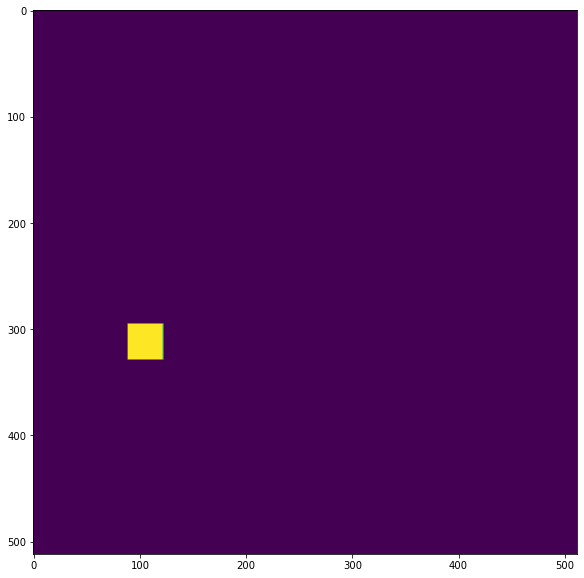

In [9]:
from PIL import Image as im
import pydicom as dicom
import numpy as np
from skimage.transform import resize

def make_masked_image(mask, output_image_dim=(1024,1024)):
#     pixel_array_numpy= dicom.dcmread(f"Images/AllData/{image_path}").pixel_array # taking the orig image to  mask over
#     #============== Normalize pixel_array for pixel values
#     pixel_array_numpy = pixel_array_numpy.astype(np.float32) / pixel_array_numpy.max()

    pixel_array_numpy = np.zeros((1024,1024), dtype = np.int16)

    for x, y in mask:
        pixel_array_numpy[x, y] = 1
    resized_img = resize(pixel_array_numpy, output_image_dim, anti_aliasing=True)
    return resized_img

mask_pixels = rle_to_pixels(mask_df.loc[7, 'mask_rle'])
img = make_masked_image(mask_pixels, (512,512))
plt.figure(figsize = (10,10))
plt.imshow(img)


# Semantic Segmentation Algorithm Development

## Step 1: Developing the training Set and Validation Set

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(mask_df, test_size = 0.3, random_state = 0)

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_df))
print('test set - # of observations): ', len(test_df))

training set - # of observations:  21
test set - # of observations):  9


## Making Training and validation Generator for batch processing

In [11]:
# Took care that the input image size is 512*512 - cv2.resize(img, dimension=(512,512))
# Notes for reference- The output image is a n-dimensional numpy array
# np.expand dims is used to convert 2d-image to 3d-image
from numpy import expand_dims
def make_img_generator(df,output_image_dim, batch_size):
    X_batch=[]
    Y_batch=[]
    
    while True:
        for img_id, mask in zip(df['anon_SOPUID'],df['mask_rle']):
            # Reading only image (which will go in X_Batch)
            pixel_array_numpy= dicom.dcmread(f"Images/AllData/{img_id}").pixel_array    #Reading the image as pixl array
            pixel_array_numpy = pixel_array_numpy.astype(np.float32) / pixel_array_numpy.max() #Normalizing the pixel values
            resized_raw_img = resize(pixel_array_numpy,output_image_dim, anti_aliasing=True) # Resizing the image to pixel size 1024*1024
            resized_raw_img = np.dstack([resized_raw_img,resized_raw_img, resized_raw_img]) #Making 1 channel image to 3 channel
            # Reading image with mask (which will go in Y_batch)
            mask_pixels = rle_to_pixels(mask)
            resized_masked_img = make_masked_image(mask_pixels,output_image_dim)
            resized_masked_img = expand_dims(resized_masked_img, axis=2)
            
        X_batch+=[resized_raw_img]
        Y_batch+=[resized_masked_img]
        
        if len(X_batch)>=batch_size:
            yield np.stack(X_batch,0),np.stack(Y_batch,0)
            X_batch, Y_batch=[],[]    

In [12]:
output_image_dim=(512,512)
BATCH_SIZE=4

train_gen =make_img_generator(train_df,output_image_dim,BATCH_SIZE)
test_gen =make_img_generator(test_df,output_image_dim,BATCH_SIZE)
train_x, train_y = next(train_gen)
print('train_X', train_x.shape)
print('train_Y', train_y.shape)

train_X (4, 512, 512, 3)
train_Y (4, 512, 512, 1)


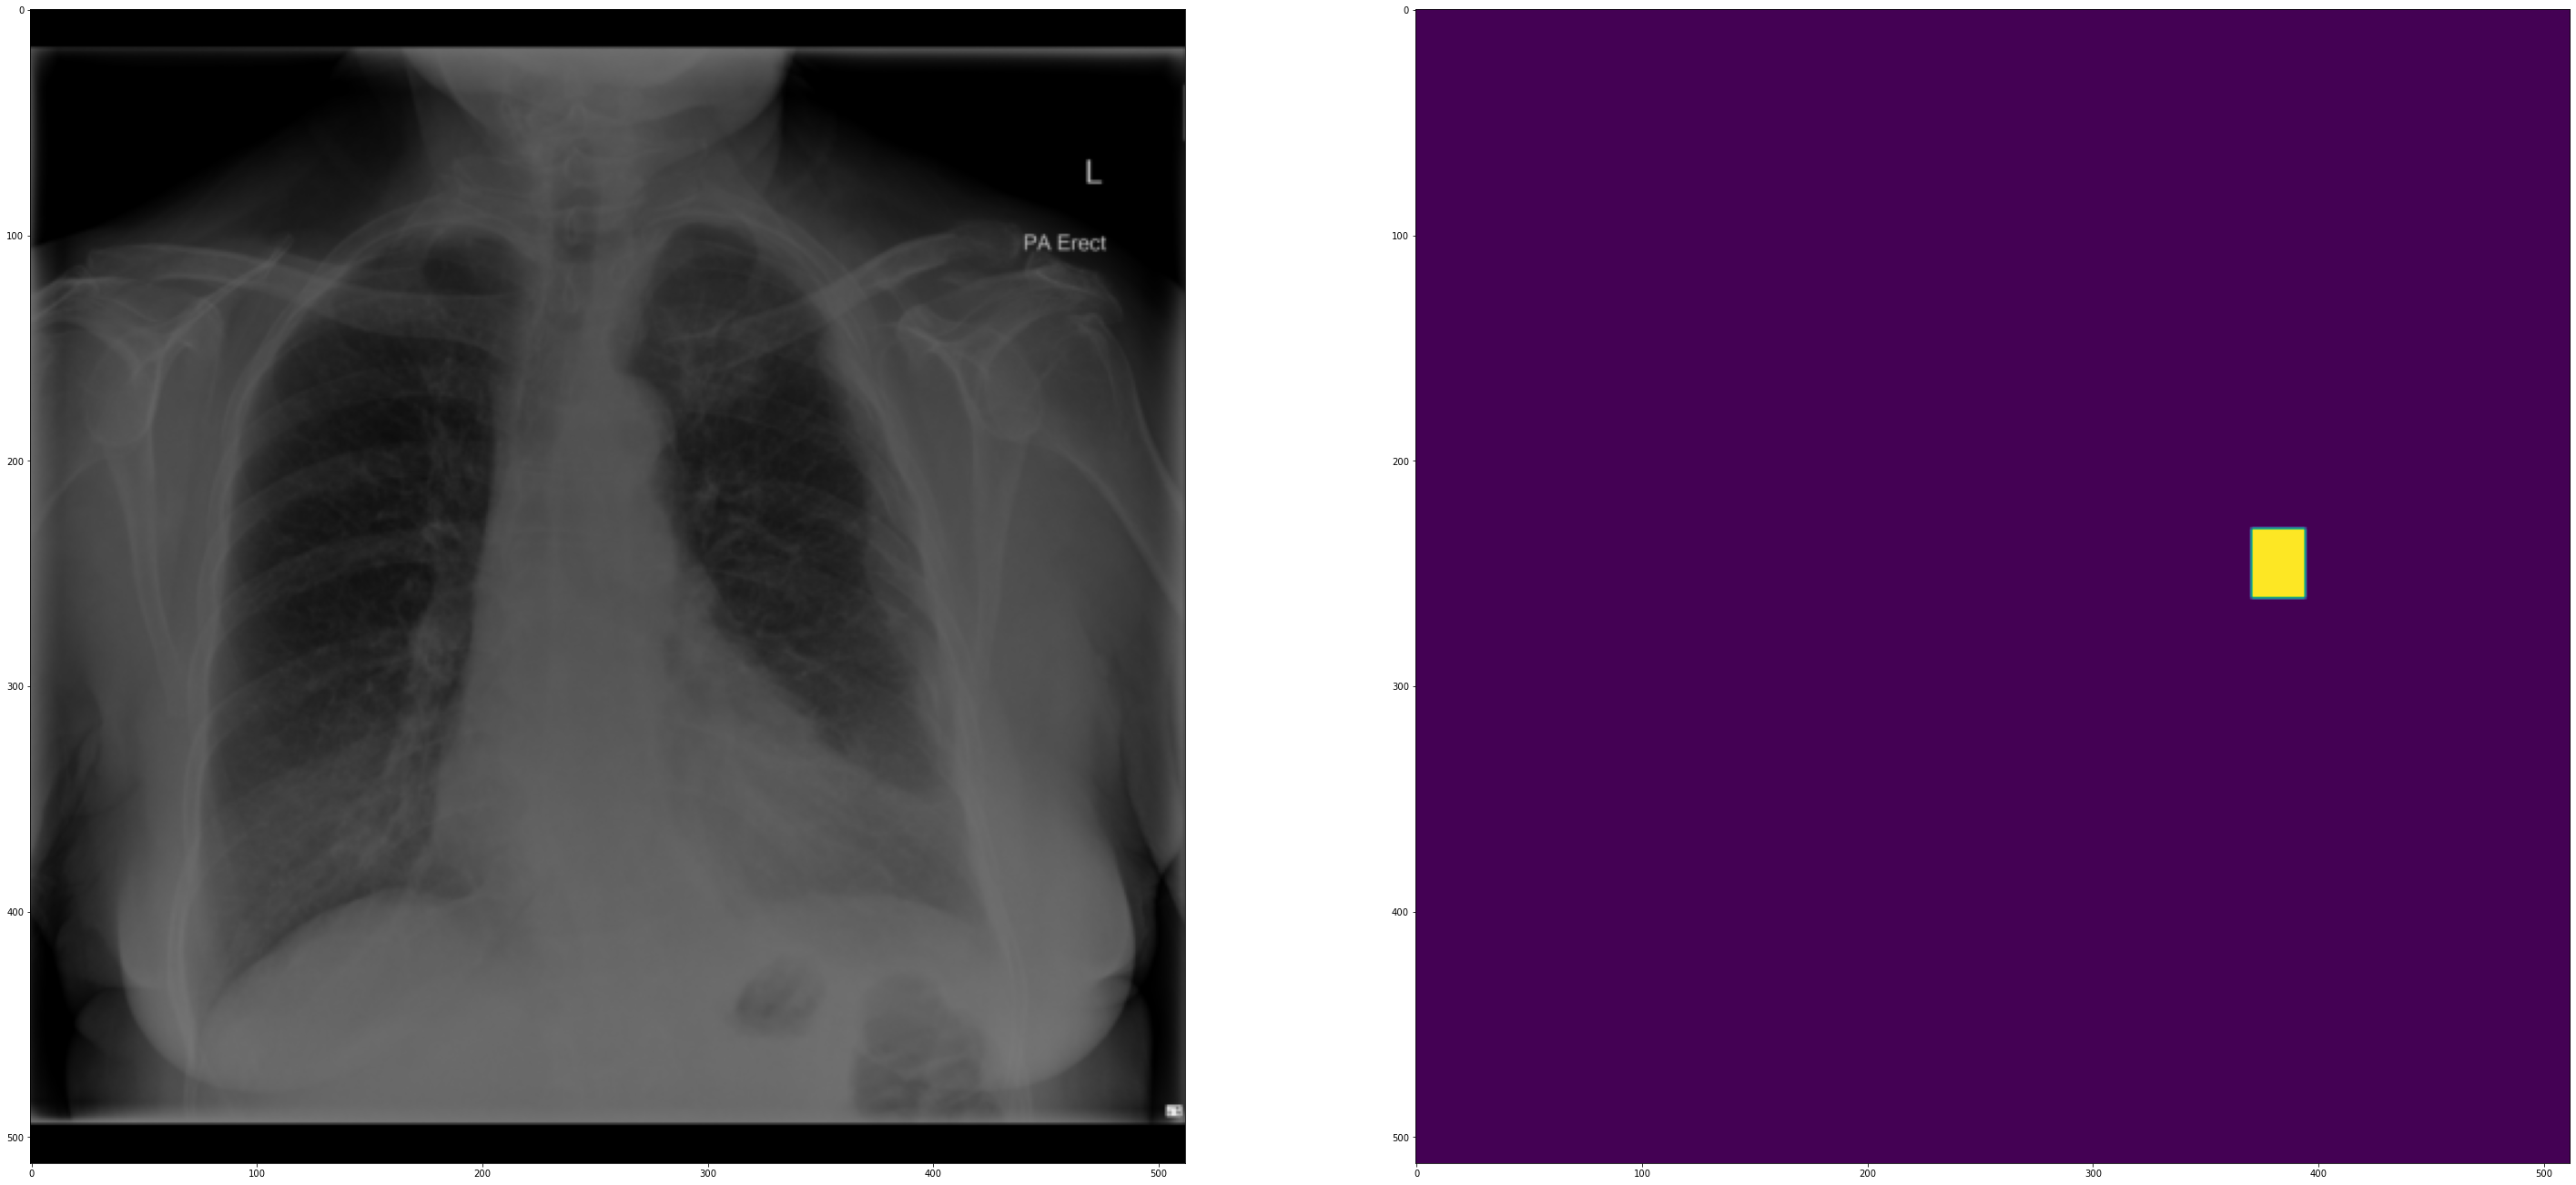

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize =(50,50))
ax1.imshow(train_x[0])
ax2.imshow(train_y[0])

## Keras Functional API Model 

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [63]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('RIB_FRACTURE',monitor='val_loss', mode='auto', verbose=1, save_best_only= True, save_weights_only=False)
early = EarlyStopping(patience=8) 
callbacks_list = [checkpoint, early]

In [64]:
step_count=len(train_df)//BATCH_SIZE +1
val_steps=len(test_df)//BATCH_SIZE +1
NB_EPOCHS=10

In [65]:
import segmentation_models as sm
optim = keras.optimizers.Adam(0.001)

# Class 1 is mask making background 0. If we use binary focal loss (weighted binary cross entropy), we can address the class imbalance problem.
total_loss= sm.losses.BinaryFocalLoss(alpha=0.01, gamma=0.1)
metrics = [sm.metrics.Recall(class_weights=[1,1])]
unet_model = sm.Unet(backbone_name='resnet34', input_shape=(512, 512, 3), classes=1 ,encoder_weights='imagenet')
unet_model.summary()

# compile keras model with defined optimizer, loss and metrics
unet_model.compile(optim,total_loss , metrics)


Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_273 (ZeroPadding (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_273[0][0]         
___________________________________________________________________________________________

In [47]:
# tf.keras.utils.plot_model(unet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [58]:
model = unet_model.fit(train_gen,steps_per_epoch=step_count, 
                       epochs=NB_EPOCHS, validation_data=test_gen,
                       validation_steps=val_steps, callbacks=callbacks_list, verbose=1)


Epoch 1/10
6/6 [==============================] - 104s 17s/step - loss: 0.6352 - recall: 0.4805 - val_loss: 0.1875 - val_recall: 0.1543

Epoch 00001: val_loss improved from inf to 0.18751, saving model to RIB_FRACTURE


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/10
6/6 [==============================] - 78s 13s/step - loss: 0.3791 - recall: 0.3433 - val_loss: 0.2237 - val_recall: 0.1713

Epoch 00002: val_loss did not improve from 0.18751
Epoch 3/10
6/6 [==============================] - 72s 12s/step - loss: 0.2644 - recall: 0.2605 - val_loss: 5.1241 - val_recall: 0.8491

Epoch 00003: val_loss did not improve from 0.18751
Epoch 4/10
6/6 [==============================] - 70s 12s/step - loss: 0.1908 - recall: 0.2006 - val_loss: 4.9998 - val_recall: 0.8787

Epoch 00004: val_loss did not improve from 0.18751
Epoch 5/10
6/6 [==============================] - 71s 12s/step - loss: 0.1389 - recall: 0.1542 - val_loss: 2.8845 - val_recall: 0.8444

Epoch 00005: val_loss did not improve from 0.18751
Epoch 6/10
6/6 [==============================] - 71s 12s/step - loss: 0.1047 - recall: 0.1216 - val_loss: 2.0662 - val_recall: 0.7220

Epoch 00006: val_loss did not improve from 0.18751
Epoch 7/10
6/6 [==============================] - 69s 11s/step - 

In [59]:
model.history

{'val_loss': [0.1875060349702835,
  0.2237110286951065,
  5.124111652374268,
  4.999752044677734,
  2.8844711780548096,
  2.0662472248077393,
  0.9376883506774902,
  0.7244033813476562,
  0.41805148124694824],
 'val_recall': [0.154275581240654,
  0.17129802703857422,
  0.8491012454032898,
  0.8786726593971252,
  0.8444428443908691,
  0.7219765782356262,
  0.42927655577659607,
  0.40059223771095276,
  0.32592058181762695],
 'loss': [0.6351571182409922,
  0.37907979389031726,
  0.2644352192680041,
  0.1907771204908689,
  0.13887794812520346,
  0.1046575978398323,
  0.08142685020963351,
  0.06507539997498195,
  0.05359923715392748],
 'recall': [0.4805143,
  0.34328952,
  0.260461,
  0.20056444,
  0.15420108,
  0.12158891,
  0.09807363,
  0.080683,
  0.068074994]}

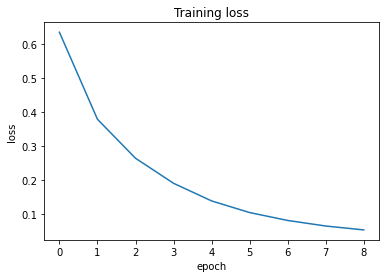

In [72]:
plt.plot(model.history['loss'])
# plt.plot(model.history['val_loss'])
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
plt.show()

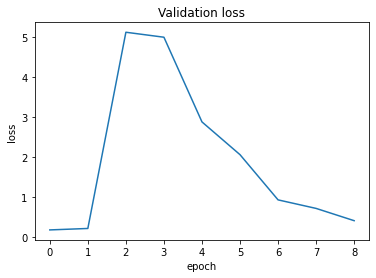

In [67]:
# plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model.save('Rib_fracture_segmentation_0.001lr_adam_0.27loss_10epochs.h5')

In [ ]:
loaded_model= load_model("Rib_fracture_segmentation_0.01lr_adam_0.27loss_10epochs.h5", compile=False)